<img src="https://assets.rbl.ms/1615279/1200x400.jpg"/>

## Hearthstone

Hearthstone, originally known as **Hearthstone: Heroes of Warcraft**, is a free-to-play online collectible card video game developed and published by Blizzard Entertainment.
Read more at <a href="https://en.wikipedia.org/wiki/Hearthstone_(video_game)">this page</a>

The game is a turn-based card game between two opponents, using constructed decks of thirty cards along with a selected hero with a unique power.

There are several modes in this game, we will be talking about **Ranked play mode only**

## Ranked play fundamentals

In Ranked Play, players duel other players to increase their ranking. Clicking on the Ranked crossed-swords button in the top-right corner of the hero panel after choosing a hero will switch from "Casual" to "Ranked" Play. Ranked Play is technically a sub-play mode of Play mode, since you can only get to it after hitting "Play", but operates very differently from "Casual" mode.

When a player selects Ranked Play mode for the first time they start at Rank 25: Angry Chicken. In Ranked Play players are pitted against opponents of approximately equal rank to their own. Every win rewards a star above the player's medal. Enough stars provide the opportunity to advance to the next rank. Win streaks increase the pace at which stars are gained. At Rank 20 every loss will cause the loss of a star. Players no longer benefit from the Win streak bonus at Rank 5 through Rank 1, so every match counts in the higher rankings.

Ranked Play makes the path to move up in the rankings more transparent and gives top-level players more ways to differentiate themselves from each other.

* Players will be matched against players of similar rank
* Win a game, acquire a star!
* Acquire enough stars and you’ll rank up!
* Each rank has its own icon and medal
* Win streaks (2 consecutive wins) will give 1 additional star (only applicable up to rank 5)
* At rank 20 or better, you'll lose a star if you lose a game
* Upon achieving certain milestones in Ranked Play, it is not possible to lose ranks beyond those milestones for that season. The milestones are Rank 20, 15, 10, 5, and Legend. 
    
For more details - read <a href="http://hearthstone.wikia.com/wiki/Ranked_Play">this article</a>

## Motivation

I was driven to create this notebook by several reasons:
* A try to improve an old calculator http://pokerdope.com/number-of-games-to-reach-legend-in-hearthstone/, adapting it to new rules and make it more flexible to use by people, **who want to estimate their chances and a time complexity of climbing onto some given rank**.
* A try to make these calculation transparent - ready to be used further by game/community enthusiasts
* To show, how a simple Monte-Karlo simulation can help you a lot for modelling more complex processes - when you're are **unable to find analytical form** of a solution and/or **it's slightly difficult task**. The only thing needs to be done - a conversion of a formal set of rules into a mathematical model of real world's process.
* I love Python and Data Visualization, so I'd like to share my experience of **how to visualize some stuff with more unusual example than Titanic dataset is :D**
* I just love Hearthstone!

So, let's start building our ranked play ladder simulation

## Import

In [1]:
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
from bisect import bisect_right
from pandas import Series
%matplotlib inline

## Variables initialization

In [2]:
# path_length
points_to_climb = (
    5*2 # from rank 25 to rank 21 (inclusive), 2 victories needed
    + 5*3 # from rank 20 to rank 16 (inclusive), 3 victories needed
    + 5*4 # from rank 15 to rank 11 (inclusive), 4 victories needed
    + 10*5 # from rank 10 to rank 1 (inclusive), 5 victories needed
    # totals = 95 stars between the rank 25(0 stars) and the legend (rank 0)
)

# rank dictionary, rank: (stars_to_reach, rank_title)
rank_to_stars = {
    25: ( 0, 'Angry Chicken'),
    24: ( 2, 'Leper Gnome'),
    23: ( 4, 'Argent Squire'),
    22: ( 6, 'Murloc Raider'),
    21: ( 8, 'Southsea Deckhand'),
    20: (10, 'Shieldbearer'),
    19: (13, 'Novice Engineer'),
    18: (16, "Sorcerer's Apprentice"),
    17: (19, 'Tauren Warrior'),
    16: (22, 'Questing Adventurer'),
    15: (25, 'Silvermoon Guardian'),
    14: (29, 'Raid Leader'),
    13: (33, 'Dread Corsair'),
    12: (37, 'Warsong Commander'),
    11: (41, 'Big Game Hunter'),
    10: (45, 'Ogre Magi'),
    9 : (50, 'Silver Hand Knight'),
    8 : (55, 'Frostwolf Warlord'),
    7 : (60, 'Sunwalker'),
    6 : (65, 'Ancient Of War'),
    5 : (70, 'Sea Giant'),
    4 : (75, 'Mountain Giant'),
    3 : (80, 'Molten Giant'),
    2 : (85, 'The Black Knight'),
    1 : (90, 'Innkeeper'),
    0 : (95, 'Legend')  
}

# inverse rank dictionary, minimum stars: (correspondent_rank, rank_title)
stars_to_rank = {v[0]:(k, v[1]) for (k, v) in rank_to_stars.items()}

# no drops below specified rank when reached (you can drop only above at rank 20)
# measured in stars; (25,24,23,22,21, 20, 15, 10, 5, 0) ranks respectively
milestones = [0,2,4,6,8, 10, 25, 45, 70, 95]

### Handy Rank Icons

In [3]:
# use rank icons to draw it next to the textual data
from skimage import io

# rank 25-1 icons + legend icon
links = ["http://www.boostinghearthstone.com/files/levels/" + str(i) + ".png" 
         for i in range(0,26)]

# download icon and return it as bytes array
def get_icon(rank=0):
    """
    Retrieves selected rank icon from the internet
    
    Parameters
    ----------
    rank: int
        Your rank (25 to 0)
    
    Returns
    -------
    out : ndarray
        numpy array of bytes, to be used for further visualization
        The different color bands/channels are stored in the third dimension, 
        such that a grey-image is MxN, an RGB-image MxNx3 and an RGBA-image MxNx4.
    """
    image = io.imread(links[rank])
    return image
    

'''
# old approach, to use icons offline (download them)
import urllib.request

def download_web_image(url, name):
    full_name = str(name) + ".png"
    urllib.request.urlretrieve(url, full_name)
    
   
for i,p in enumerate(links):
    download_web_image(p, 'icons//rank'+str(25-i))    
'''
pass

## Supportive functions

In [4]:
# seasonal bonus
def last_season_bonus(rank=25):
    """
    Calculates, how many additional stars will be added from previous season's acievements.
    Additional stars = (25 - previous season rank)
    
    Parameters
    ----------
    rank: int
        Rank, gained in previous season
    
    Returns
    -------
    out : int
        Additional stars, gained as a bonus from previous season achievements
    """
    assert (type(rank) == int and  0 <= rank <= 25), 'check rank! (integer, between 0(Legend) and 25 (Angry Chicken))'
    return 25 - rank

# you're defeated in a current game
def defeat(current_stars):
    """
    Calculates, how many stars you will lose when you're defeated (based on current star amount).
    Fall, but not lower than a highest gained milestone
    say, if you're on lvl 15 (0 stars) == 25 points, you cannot fall, defeat(25) = 25
    your winstreak will be set up to 0 again
    
    Parameters
    ----------
    current_stars: int
        Your rank, measured in stars (0 to 95)
    
    Returns
    -------
    out : int
        Recalculated rank, measured in stars (0 to 95)
    """
    highest_milestone = milestones[bisect_right(milestones, current_stars)-1] # highest milestone
    return current_stars-1 if current_stars > highest_milestone else current_stars

# you win in a current game
def win(current_stars, winstreak=0):
    """
    Calculates, how many stars you will gain when you win current match 
    (based on current star amount, consecutive victories and rank).
    
    Parameters
    ----------
    current_stars: int
        Your rank, measured in stars (0 to 95)
    winstreak: int
        # of consecutive victories (>= 0), when 3+ -> gain 1 additional star until you reach rank 5
    
    Returns
    -------
    out : int
        Recalculated rank, measured in stars (0 to 95)
    """
    if winstreak > 2 and current_stars < milestones[-2]:
        return min(milestones[-1], current_stars + 2)
    else:
        return min(milestones[-1], current_stars + 1)

# game imitation (random draw from Bernoulli trial)
def game(win_probability=0.5):
    """
    Imitate a game given the probability to win (say, your average deck winrate)
    
    Parameters
    ----------
    win_probability: float
        Average deck winrate (0.0 to 1.0)
    winstreak: int
        # of consecutive victories (>= 0), when 3+ -> gain 1 additional star until you reach rank 5
    
    Returns
    -------
    out : int
        Game result: 0 = defeat, 1 = victory
    """
    assert (type(win_probability) == float and  0.0 <= win_probability <= 1.0), \
    "Use floats for winrates, 0.0 <= wr <= 1.0"
    r = random.rand() # generate uniformly distributed random number ~ U([0;1])
    return int(r <= win_probability)

## Main functions

In [5]:
# imitate a series of games (length X)
def generate_series(length=1000, 
                    wr5=0.5, wr_up5=0.5,
                    prev_season_rank=25,
                    current_rank=25, level_stars=0,
                    new_season=True, winstreak=0, desired_rank=0):
    """
    Imitate a series of games (of length X) given win probabilities
    target = to reach desired rank X (0=Legend, ..., 25=Angry Chicken)
    
    Parameters
    ----------
    length: int
        Series length, # of games to play
    wr5: float
        Average deck winrate below rank 5 (0.0 to 1.0)
    wr_up5: float
        Average deck winrate on rank 5 or above (0.0 to 1.0)
    prev_season_rank: int
        Rank, obtained in previous season (25 to 0). Used only if new_season=True
    current_rank: int
        Your current rank (25 to 0), if you've already played some games in current season
    level_stars: int
        Your current rank's stars (0 to 5), if you've already played some games in current season
    new_season: bool
        Indicates, what rank to use: bonus from previous season (if True) or current_rank + level_stars (otherwise)
    winstreak: int
        # of consecutive victories (>= 0)
    desired_rank: int
        Desired rank (25 to 0) you want to reach from your current
    
    Returns
    -------
    out : tuple
        out[0]: int
            # of games played to reach desired rank, -1 if desired rank was not reached in this run
        out[1]: int
            The highest rank, reached in this run (25 to 0, <= desired_rank)
        out[2]: list
            A list of stars, gained through a run, len = 1 + length
    """
    
    # current stars
    if new_season:
        curr_stars = last_season_bonus(prev_season_rank) # to start anew
    else:
        curr_stars = rank_to_stars[current_rank][0] + level_stars
        
    # check whether you already gained desired rank :)
    assert rank_to_stars[desired_rank][0] > curr_stars, "You're already on your  desired rank or above o_0"  
    
    stars_to_gain = rank_to_stars[desired_rank][0] # define # of stars for desired level to reach
    reached = False # rank is not reached yet 
    
    # winrate (empirically/statistically, winrates below and above 5th rank are different)
    wr = wr5 if curr_stars < 70 else wr_up5
    
    # say, if you simulate a start already having a winstreak
    winstreak = winstreak 
    
    # list of stars gained
    stars = []
    stars.append(curr_stars) # zero step (current rank)
    
    # let's start...
    for i in range(1, length+1):
        # play a game(round)
        result = game(wr)
        
        # victory!
        if result:
            winstreak += 1
            curr_stars = win(curr_stars, winstreak)
        # or - defeated...
        else:
            curr_stars = defeat(curr_stars)
            winstreak = 0
        
        # save current progress
        stars.append(curr_stars)
        
        # check for 5th rank to switch winrates
        wr = wr5 if curr_stars < 70 else wr_up5
        
        # desired rank is reached, we can stop now
        if curr_stars >= stars_to_gain:
            reached = True
            break
    
    # return no of steps to reach achieved rank (if achieved) and highest rank (<= desired rank)
    rnk = bisect_right([k for k in sorted(stars_to_rank.keys(), reverse=False)], curr_stars)
    return (i if reached else -1, len(rank_to_stars) - rnk, stars)


# simulate random climbings
def simulate(n_series=1000, **generate_series_params):
    """
    Simulate X random climbings, based on **generate_series_params
    
    Parameters
    ----------
    n_series: int
        How many runs to simulate, >= 1
    generate_series_params: dict
        Parameters to be passed to generate_series()
    
    Returns
    -------
    out : tuple
        out[0]: numpy array 
            # of games played to reach desired rank, -1 if desired rank was not reached in a run, shape=(n_series, )
        out[1]: numpy array 
            The highest rank, reached in this run (25 to 0, <= desired_rank), shape=(n_series, )
        out[2]:
            A list of lists of stars, gained through a run, len = n_series
    """
    params = generate_series_params
    
    # initialize ranks and games_played
    ranks = np.zeros(n_series) - 1
    games_played = np.zeros(n_series) - 1
    stars = []
    
    # get star limits as keys to ranks
    ks = [k for k in sorted(stars_to_rank.keys(), reverse=False)]
    
    # run it
    for i in range(n_series):
        games_played[i], ranks[i], st = generate_series(**params)
        stars.append(st) # save star path of a single run
    
    if params['new_season']:
        cr = len(rank_to_stars) - bisect_right(ks, last_season_bonus(params['prev_season_rank']))
    else:
        cr = params['current_rank']

    # desired rank
    dr = params['desired_rank']
    
    # max gained rnk
    mgr = ranks[ranks >= 0].min().astype(int)
    
    # supportive plotting
    labels = ['Starting at rank {}({})', 'Want to achieve rank {}({})', 'Highest rank gained: {}({})']
    ranks_to_show = [cr, dr, mgr]
    
    f, ax = plt.subplots(1, len(labels), squeeze=False, figsize=(16, 5))
    f.suptitle('Playing {} games with ({:.1f}% < 5th rank, {:.1f}% >= 5th rank) winrates, {} simulations'.format(
                                                                            params['length'], 
                                                                            params['wr5']*100.0,
                                                                            params['wr_up5']*100.0,
                                                                            n_series
                                                                              ))
    for i in range(len(labels)):
        ax[0, i].set_title(labels[i].format(ranks_to_show[i], rank_to_stars[ranks_to_show[i]][1]))
        ax[0, i].imshow(get_icon(ranks_to_show[i]))
        ax[0, i].axis('off')
    
    return ranks, games_played, stars

## Visualizations and distributions

In [6]:
# statistics and distributions
def calculate_stats(ranks, games):
    """
    Given simulation results, calculate and visualize some statistics
    
    Parameters
    ----------
    ranks: numpy array
        highest ranks, achieved in simulations (integers, 0 to 25)
    games: numpy array
        # of games played to achieve desired ranks (integers), -1 for those runs, unable to reach a rank
    
    Returns
    -------
    None
    """
    
    # a kind of cdf (average, to climb up to rank X in a run of N simulated games)
    possible_ranks = len(rank_to_stars)
    probabilities = np.zeros(possible_ranks)
    for i in range(possible_ranks):
        probabilities[i] = 1.0 * len(ranks[ranks <= possible_ranks - i]) / ranks.shape[0]
    plt.figure(figsize=(16, 4))
    s = Series.from_array(probabilities)*100
    s.plot(kind='bar')
    plt.title('Probability to reach given rank')
    for y in range(0, s.max().astype(int), s.max().astype(int)//5):  
        plt.plot(range(0, possible_ranks), [y] * possible_ranks, "--", lw=0.5, color="black", alpha=0.3)
    
    plt.xticks(list(range(25,-1,-1)))
    plt.xlabel('Ranks (25=Angry Chicken, 0=Legend)', fontsize=14)
    plt.ylabel('Probability, %', fontsize=14)
    
    # rank distribution
    plt.figure(figsize=(16, 4))
    s = Series.from_array(np.bincount((25 - ranks).astype(int)))
    s = s/s.sum()*100 # norm to 100% (probabilities)
    s.plot(kind='bar')
    plt.title('Rank distribution')
    for y in range(0, s.max().astype(int), s.max().astype(int)//5):  
        plt.plot(range(0, possible_ranks), [y] * possible_ranks, "--", lw=0.5, color="black", alpha=0.3)
    plt.xticks(list(range(25,-1,-1)))
    plt.xlabel('Ranks (25=Angry Chicken, 0=Legend)', fontsize=14)
    plt.ylabel('density $p(x)$, %', fontsize=14)
    
    # average # of games to reach rank
    plt.figure(figsize=(16, 4))
    plt.hist(games[games > 0], edgecolor='w', linewidth=2)
    plt.title('Run lengths (# of games)')
    plt.xlabel('Games played, #', fontsize=14)
    plt.ylabel('Successful runs, #', fontsize=14)
    plt.xlim([max(0, games[games > 0].min()-5), games[games > 0].max()+5] 
             if games[games > 0].shape[0] else [0,1])

    
# visualize random climbings for different winrates
def visualize_climbing(winrates=[0.5], **series_params):
    """
    Visualization of random climbings, based on different winrates
    Based on https://github.com/stevesebastian/Hearthstone-Ladder-Simulation-iPython-Notebook/
    
    Parameters
    ----------
    winrates: list
        a list of winrates to visualize
    series_params: dict
        Parameters to be passed to generate_series()
    
    Returns
    -------
    None
    """    
    
    xrange = 0 # x range for plot
    legends = [] # series legends
    handles = [] # plot handles
    
    # create figure to draw onto
    plt.figure(figsize=(16, 9))
    ax = plt.subplot(111) 
    
    ax.spines["top"].set_visible(False)   
    ax.spines["right"].set_visible(False)    
    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left()
    
    # simulate climbings for given winrates
    for w in sorted(winrates):
        series_params.update({'wr5': w, 'wr_up5': w})
        _, _, stars = generate_series(**series_params)
        xrange = max(xrange, len(stars))
        handles.append(plt.plot(stars, linewidth=1, ls='--', label=str(round(w*100)) + '% winrate'))
        
    # format figure -----------------------------------------------------------------------------
    plt.ylim(0, 110)  
    plt.xlim(0, xrange) 
    
    plt.yticks(range(0, 101, 10), fontsize=14)  
    plt.xticks(range(0, xrange+1, xrange//10), fontsize=14)  
    
    # plot horizontal gridlines
    for y in range(0, 101, 20):  
        plt.plot(range(0, xrange), [y] * xrange, "--", lw=0.5, color="black", alpha=0.3)  

    plt.tick_params(axis="both", which="both", bottom="off", top="off",  
                labelbottom="on", left="off", right="off", labelleft="on")  

    plt.title('Progress vs. games played', fontsize=20)
    plt.xlabel('Games played, #', fontsize=14)
    plt.ylabel('Stars gained, #', fontsize=14)
    
    # names of lines for ranks-milestones 20,15,10,5 and 0 (Legend)
    plt.text(xrange+3, 10-1, 'Rank 20', fontsize=14, color='#AAAAAA')
    plt.text(xrange+3, 25-1, 'Rank 15', fontsize=14, color='#f6d76d')
    plt.text(xrange+3, 45-1, 'Rank 10', fontsize=14, color='#E257DC')
    plt.text(xrange+3, 70-1, 'Rank 5', fontsize=14, color='#3CB371')  
    plt.text(xrange+3, 95-1, 'Legend', fontsize=14, color='#ffb900')
    
    # plot lines for ranks-milestones 20,15,10,5 and 0 (Legend)
    plt.plot([0, xrange], [10, 10], linewidth=1, color='#AAAAAA', ls=':')
    plt.plot([0, xrange], [25, 25], linewidth=1, color='#f6d76d', ls=':')
    plt.plot([0, xrange], [45, 45], linewidth=1, color='#E257DC', ls=':')
    plt.plot([0, xrange], [70, 70], linewidth=1, color='#3CB371', ls=':')
    plt.plot([0, xrange], [95, 95], linewidth=1, color='#ffb900', ls=':')
    
    # plot desired rank (if not one of abovementioned milestones)
    if series_params['desired_rank'] not in [20, 15, 10, 5, 0]:
        rank_stars = rank_to_stars[series_params['desired_rank']][0]
        plt.plot([0, xrange], [rank_stars, rank_stars], linewidth=1, color='b', ls=':')
        plt.text(xrange+3, rank_stars-1, 'Desired Rank', fontsize=14, color='b')
    
    # draw legends
    plt.legend(handles=[h[0] for h in handles], loc=4)
    

## Simulation itself

Wall time: 2.71 s


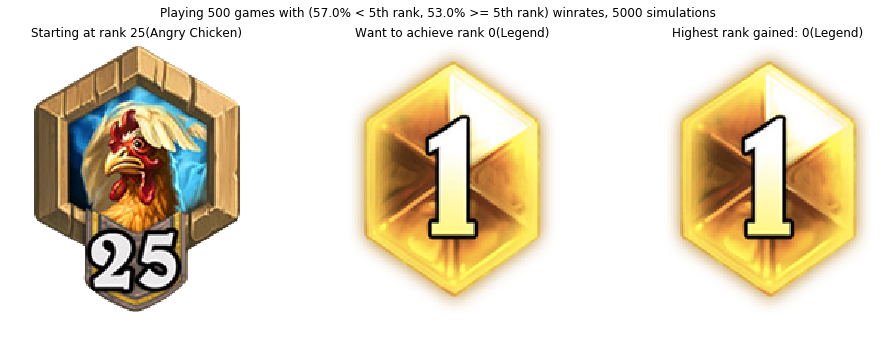

In [7]:
%%time

# parameters for a simulation
n_series = 5000 # how many runs to simulate

series_params = {
    'length': 500, # how many games a single run consists of
    'wr5': 0.57, # average deck/player winrate (below 5th rank)
    'wr_up5': 0.53, # average deck/player winrate (>= 5th rank)
    
    # if True - calculate last season rank bonus and start anew
    'new_season': False, 
    'prev_season_rank': 25,
    
    # if you obtained some progress (to start from rank x, with y stars)
    'current_rank': 25, 
    'level_stars': 0,
     
    'winstreak': 0, # (number of consecutive wins) - whether you're on a winstreak (>=3 - yes)
    'desired_rank': 0
}

# run it
r, g, s = simulate(n_series=n_series, **series_params)

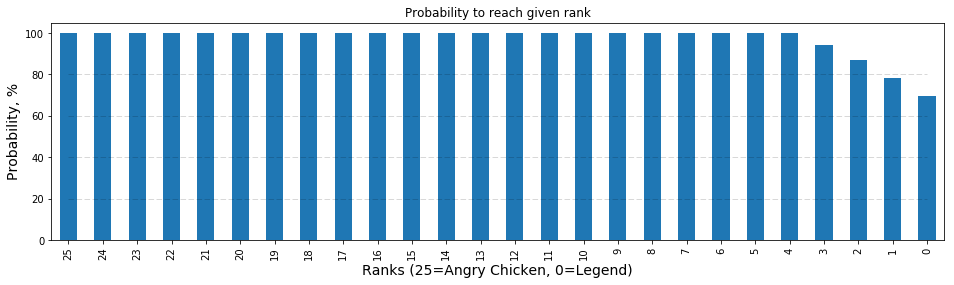

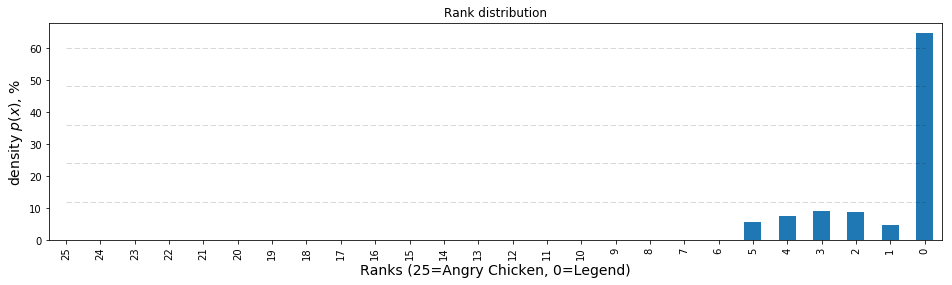

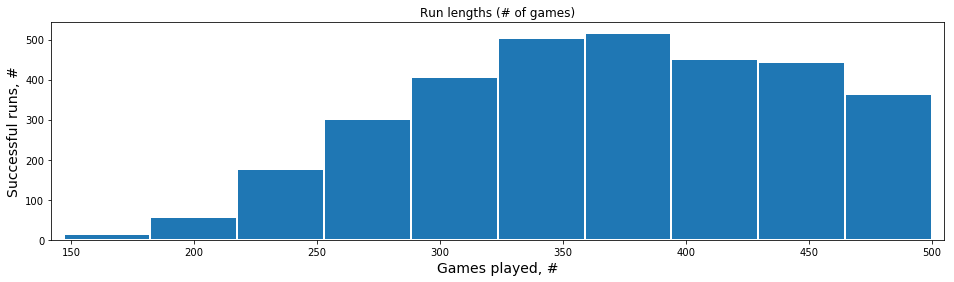

In [8]:
# let's visualize some stats
calculate_stats(r, g)

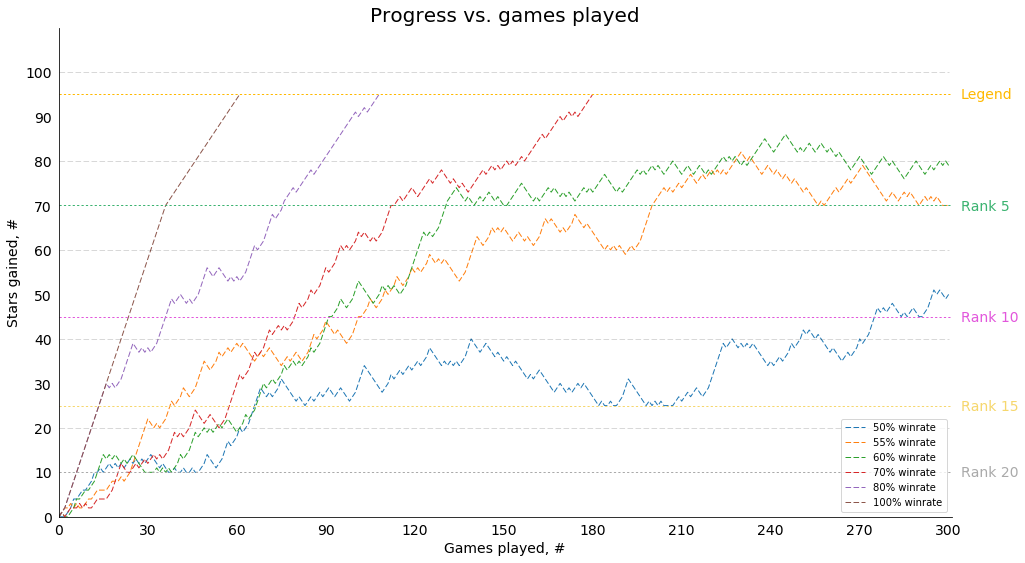

In [9]:
# let's see, how climbing length depends on winrates
sp = {
    'length': 300, # how many games a single run consists of
    
    # if True - calculate last season rank bonus and start anew
    'new_season': False, 
    'prev_season_rank': 25,
    
    # if you obtained some progress (to start from rank x, with y stars)
    'current_rank': 25, 
    'level_stars': 0,
     
    'winstreak': 0, # whether you're on a winstreak (>=3 - yes)
    'desired_rank': 0 # a rant to reach (25,...0 - Legend)
}

# visualize climbing examples for selected winrates
visualize_climbing(winrates=[0.5, 0.55, 0.6, 0.7, 0.8, 1.0], **sp)

## That's all, thanks for reading

This notebook can be forked on GitHub:<br>
https://github.com/fred-navruzov/hearthstone-ladder-simulation